### **Import Libraries and Read Data**

In [27]:
import numpy as np
import pandas as pd
import seaborn as sns

In [28]:
train = pd.read_excel("trainDATA.xlsx", index_col = None)
test = pd.read_excel("testDATA.xlsx", index_col = None)

In [29]:
X = train.iloc[:,:-1].to_numpy()
Y = train.iloc[:,-1:].to_numpy()

test_X = test.iloc[:,:].to_numpy()
text_Y = []

### **Define Model**

In [30]:
class Node:
  def __init__(self, left=None, right=None, feature=None, value=None, leaf=False):
    self.left = left
    self.right = right
    self.feature = feature
    self.value = value
    self.leaf = leaf

  def is_leaf(self):
    return self.leaf


In [31]:
max_depth = 3

def calculate_entropy(Y):
  n_samples = len(Y)
  _, counts = np.unique(Y, return_counts=True)

  entropy = 0
  for count in counts:
    p = count / n_samples
    entropy += -p * np.log2(p)

  return entropy

def calculate_gain(Y, Y_left, Y_right):
  p = len(Y)
  p_left = len(Y_left)
  p_right = len(Y_right)

  parent_entropy = calculate_entropy(Y)
  left_entropy = calculate_entropy(Y_left)
  right_entropy = calculate_entropy(Y_right)

  gain = parent_entropy - (p_left / p) * left_entropy - (p_right / p) * right_entropy
  return gain

def split_data(X, Y, feature, value, left=True):
  if left:
    mask = X[:, feature] <= value
    return X[mask], Y[mask]
  else:
    mask = X[:, feature] > value
    return X[mask], Y[mask]

def calculate_tree(X, Y, depth):
  _, n_features = X.shape
  
  if depth >= max_depth:
    if not Y.any():
      leaf_value = None
    else:
      unique_values, counts = np.unique(Y, return_counts=True)
      leaf_value =  unique_values[np.argmax(counts)]
    return Node(leaf=True, value=leaf_value)

  best_gain = 0
  best_feature = 0
  best_value = 0

  for feature in range(n_features):
    for value in X[:, feature]:
      X_left, Y_left = split_data(X, Y, feature, value)
      X_right, Y_right = split_data(X, Y, feature, value, left=False)

      gain = calculate_gain(Y, Y_left, Y_right)

      if gain > best_gain:
        best_gain = gain
        best_feature = feature
        best_value = value

  X_left, Y_left = split_data(X, Y, best_feature, best_value)
  X_right, Y_right = split_data(X, Y, best_feature, best_value, left=False)

  left_tree = calculate_tree(X_left, Y_left, depth + 1)
  right_tree = calculate_tree(X_right, Y_right, depth + 1)

  return Node(left=left_tree, right=right_tree, feature=best_feature, value=best_value)

tree = calculate_tree(X, Y, depth=0)

In [32]:
def predict_recursive(node, x):
  if node.is_leaf():
    return node.value
  
  feature = node.feature
  value = node.value
  if x[feature] <= value:
    return predict_recursive(node.left, x)
  else:
    return predict_recursive(node.right, x)
    
def predict(X):
  y_pred = []
  for x in X:
    y_pred.append(predict_recursive(tree, x))
  return np.array(y_pred)

### **Predict Data**

In [33]:
predicted_Y = predict(X)
test_Y = predict(test_X)

### **Calculate Confusing Matrix**

In [34]:
true_positive = np.sum(np.logical_and(predicted_Y == 2, Y.flatten() == 2))
true_negative = np.sum(np.logical_and(predicted_Y == 1, Y.flatten() == 1))
false_positive = np.sum(np.logical_and(predicted_Y == 2, Y.flatten() == 1))
false_negative = np.sum(np.logical_and(predicted_Y == 1, Y.flatten() == 2))
 
print ('True Negative: %i, False Negative: %i \nFalse Positive: %i, True Positive: %i' % (true_negative,false_negative,false_positive,true_positive))

True Negative: 957, False Negative: 139 
False Positive: 37, True Positive: 167


<AxesSubplot: >

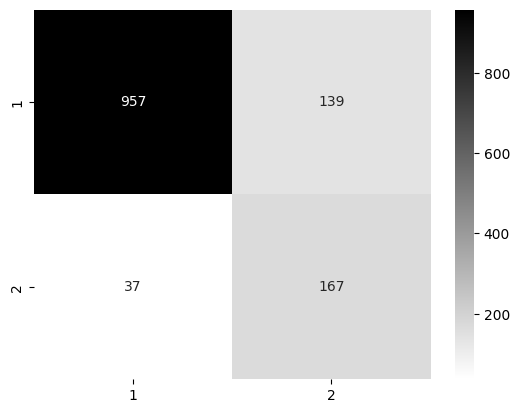

In [35]:
confusing_matrix = [[true_negative,false_negative],
                    [false_positive,true_positive]]
                    
sns.heatmap(confusing_matrix, annot=True, fmt='g', cmap='binary', xticklabels=[1,2], yticklabels=[1,2])

### **Calculate Metrics**

In [36]:
accuarcy_score = (true_positive + true_negative) / (true_positive + true_negative + false_positive + false_negative) 
print("Accuarcy Score:", accuarcy_score)

Accuarcy Score: 0.8646153846153846


In [37]:
precision_score = true_positive / (true_positive + false_positive) 
print("Precision Score:", precision_score)

Precision Score: 0.8186274509803921


In [38]:
recall_score = true_positive / (true_positive + false_negative) 
print("Recall Score:", recall_score)

Recall Score: 0.545751633986928


In [39]:
f1_score = (2 * precision_score * recall_score) / (precision_score + recall_score) 
print("F1 Score:", f1_score)

F1 Score: 0.6549019607843136
